In [2]:
#导入项目中所需相关算子库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.svm import SVR
from xgboost import XGBRegressor
from matplotlib import rc

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_stata("Machine_Learning_Data_all_country.dta")

# 根据county_id筛选数据
dtrain = data[data["country"] == 5]

# 查看训练集和测试集大小
print("训练集大小：", np.shape(dtrain))


训练集大小： (88652, 47)


In [4]:
# 查看数据缺失情况
print('缺失值统计：')
print(dtrain.apply(lambda x: sum(x.isnull())))

缺失值统计：
comp_id             0
year                0
revenue           424
total_assets        0
r_and_d           424
ebitda            424
st_invest         412
cash              412
TPos                0
srad                0
pr                  0
vap                 0
vs                  0
TNeg                0
PPos                0
PNeg                0
net_income          0
op_exp              0
curr_assets         0
curr_liab           0
lt_investment       0
lt_debt             0
st_debt             0
cash_acq            0
common_rep          0
pref_rep            0
emp_count           0
mkt_cap             0
fcf              2096
div_total        4009
net_assets          0
leverage            7
market_val        412
sic                 0
country_short       0
GDP                 0
GDP_pc              0
GDP_growth          0
inflation           0
inst_own            0
public_own          0
country             0
L_TPos           7884
L_TNeg           7884
L_PPos           7884
L_P

In [5]:
# 删除包含缺失值的行
dtrain = dtrain.dropna()

# 再次查看数据缺失情况
print('缺失值统计：')
print(dtrain.apply(lambda x: sum(x.isnull())))

缺失值统计：
comp_id          0
year             0
revenue          0
total_assets     0
r_and_d          0
ebitda           0
st_invest        0
cash             0
TPos             0
srad             0
pr               0
vap              0
vs               0
TNeg             0
PPos             0
PNeg             0
net_income       0
op_exp           0
curr_assets      0
curr_liab        0
lt_investment    0
lt_debt          0
st_debt          0
cash_acq         0
common_rep       0
pref_rep         0
emp_count        0
mkt_cap          0
fcf              0
div_total        0
net_assets       0
leverage         0
market_val       0
sic              0
country_short    0
GDP              0
GDP_pc           0
GDP_growth       0
inflation        0
inst_own         0
public_own       0
country          0
L_TPos           0
L_TNeg           0
L_PPos           0
L_PNeg           0
tem              0
dtype: int64


In [6]:
import numpy as np
import pandas as pd

def winsorize_data(data):
    exclude_columns = ['comp_id', 'year', 'sic', 'country', 'country_short']
    columns_to_process = [col for col in data.columns if col not in exclude_columns]
    for col in columns_to_process:
        lower_percentile = np.percentile(data[col], 1)
        upper_percentile = np.percentile(data[col], 99)
        data[col] = np.clip(data[col], lower_percentile, upper_percentile)
    return data

In [7]:
dtrain = winsorize_data(dtrain)

In [ ]:
# 绘制热图函数
# 设置全局字体为Times New Roman
rc('font', family='Times New Roman')
def heatmap(df):
    # 排除不需要的变量
    df_filtered = df.drop(columns=['comp_id', 'country', 'country_short'])
    
    # 计算Spearman相关系数
    mcorr = df_filtered.corr(method = 'spearman')
    
    # 根据与 'CASH_EQV' 的相关系数排序
    cash_corr = mcorr['cash'].sort_values(ascending=False)
    
    # 提取排序后的数据，确保与CASH_EQV相关性最大的变量排在前面
    df_sorted = df_filtered[cash_corr.index]
    
    # 设置热图
    plt.figure(figsize=(20, 16), dpi=100)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)  # 设置颜色映射
    # 暂时去掉mask，以确保显示相关系数值
    g = sns.heatmap(df_sorted.corr(method='spearman'), cmap=cmap, square=True, annot=True, fmt='.2f',
                    annot_kws={'size': 12, 'ha': 'center', 'va': 'center'})
    
    # 旋转x轴和y轴标签
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    # 保存热图为400 dpi的图片
    plt.savefig('heatmap_correlation_USA.png', dpi=400, bbox_inches='tight')

    return cash_corr

# 使用修改后的heatmap函数
dtrain_mcorr = heatmap(dtrain)


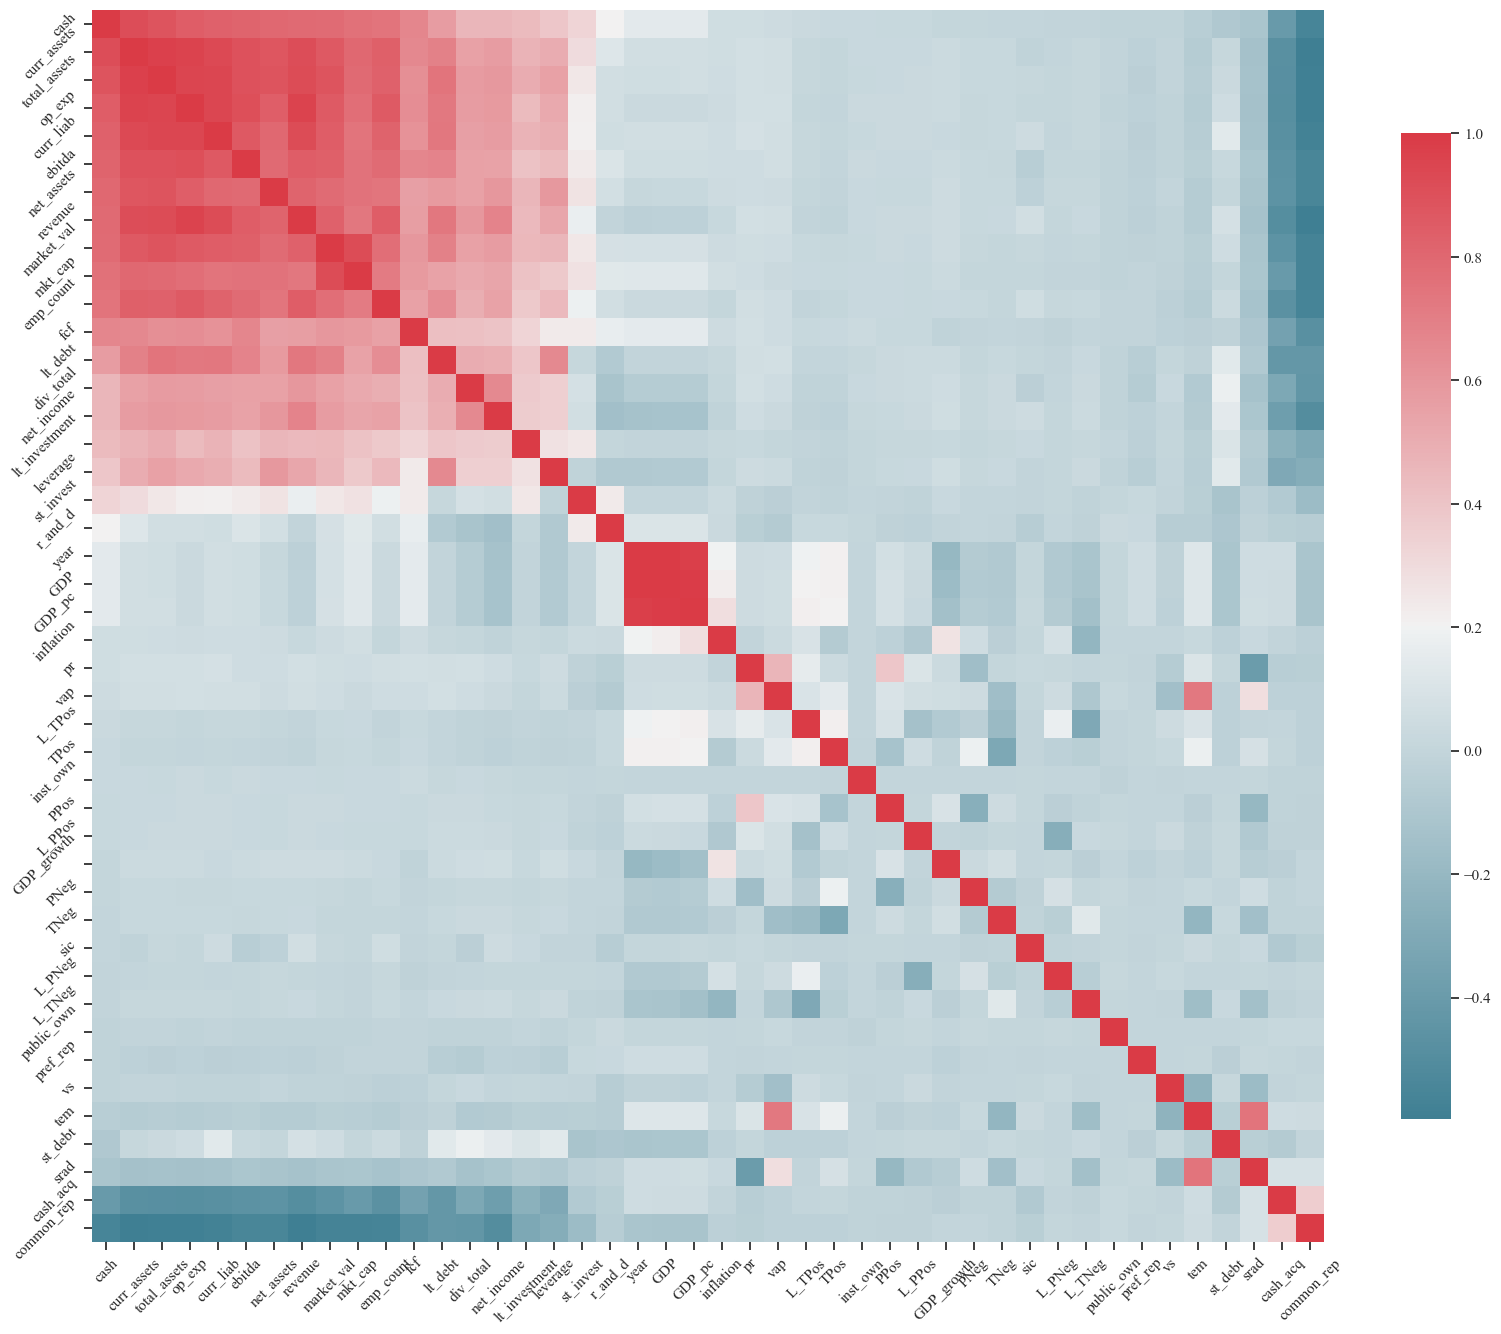

In [9]:
# 绘制热图函数
# 设置全局字体为Times New Roman
from matplotlib import rc
import seaborn as sns
import matplotlib.pyplot as plt

rc('font', family='Times New Roman')

def heatmap(df):
    # 排除不需要的变量
    df_filtered = df.drop(columns=['comp_id', 'country', 'country_short'])
    
    # 计算Spearman相关系数
    mcorr = df_filtered.corr(method='spearman')
    
    # 根据与 'cash' 的相关系数排序
    cash_corr = mcorr['cash'].sort_values(ascending=False)
    
    # 提取排序后的数据，确保与 'cash' 相关性最大的变量排在前面
    df_sorted = df_filtered[cash_corr.index]
    
    # 设置热图
    plt.figure(figsize=(20, 16), dpi=100)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)  # 设置颜色映射
    # 绘制热图，不显示数字值
    g = sns.heatmap(df_sorted.corr(method='spearman'), cmap=cmap, square=True, annot=False,  # 设置 annot=False
                    cbar_kws={'shrink': 0.8})  # 调整颜色条大小
    
    # 旋转x轴和y轴标签
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    
    # 保存热图为400 dpi的图片
    plt.savefig('heatmap_correlation_USA_no_values.png', dpi=400, bbox_inches='tight')

    return cash_corr

# 使用修改后的heatmap函数
dtrain_mcorr = heatmap(dtrain)

In [10]:
from sklearn.preprocessing import StandardScaler #特征标准化
# 提取特征和目标变量
X = dtrain.drop(columns=['comp_id', 'country', 'country_short', 'cash'])
y = dtrain['cash']

# 获取特征名称列表
feature_names = X.columns.tolist()
print("特征名称列表:")
print(feature_names)

#标准化前的变量描述性统计
import pandas as pd
X_train_df = pd.DataFrame(X)
print(X_train_df.describe())
y_train_series = pd.Series(y)
print(y_train_series.describe())

特征名称列表:
['year', 'revenue', 'total_assets', 'r_and_d', 'ebitda', 'st_invest', 'TPos', 'srad', 'pr', 'vap', 'vs', 'TNeg', 'PPos', 'PNeg', 'net_income', 'op_exp', 'curr_assets', 'curr_liab', 'lt_investment', 'lt_debt', 'st_debt', 'cash_acq', 'common_rep', 'pref_rep', 'emp_count', 'mkt_cap', 'fcf', 'div_total', 'net_assets', 'leverage', 'market_val', 'sic', 'GDP', 'GDP_pc', 'GDP_growth', 'inflation', 'inst_own', 'public_own', 'L_TPos', 'L_TNeg', 'L_PPos', 'L_PNeg', 'tem']
               year       revenue  total_assets       r_and_d        ebitda  \
count  75966.000000  75966.000000  75966.000000  75966.000000  75966.000000   
mean    2011.186254   2498.155179   3580.759266     34.431339    426.099802   
std        8.347709   7870.337751  11661.873958    161.857736   1373.390141   
min     1991.000000      0.000000      0.002440      0.000000      0.000000   
25%     2005.000000      2.090000      9.066205      0.000000      1.900000   
50%     2012.000000     93.500000    148.140500     

In [11]:
#标准化特征变量
#sc = StandardScaler()
#sc.fit(X)
#X = sc.transform(X)

In [12]:
# 将X和y转换为numpy数组
X = np.array(X)
y = np.array(y)
# 使用train_test_split进行随机划分
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=66)

In [13]:
#查看训练数据描述性统计
import pandas as pd
X_train_df = pd.DataFrame(X_train)
print(X_train_df.describe())
y_train_series = pd.Series(y_train)
print(y_train_series.describe())

                 0             1             2             3             4   \
count  60772.000000  60772.000000  60772.000000  60772.000000  60772.000000   
mean    2011.215774   2483.811914   3555.979918     34.290785    423.063555   
std        8.339357   7802.437933  11560.387549    161.285556   1361.275082   
min     1991.000000      0.000000      0.002440      0.000000      0.000000   
25%     2005.000000      2.070000      8.976527      0.000000      1.870000   
50%     2012.000000     93.200000    148.081000      0.000000     19.400000   
75%     2019.000000   1183.225000   1414.709250      1.730000    171.925000   
max     2023.000000  58255.400000  84994.250000   1311.120000  10059.050000   

                 5             6             7             8             9   \
count  60772.000000  60772.000000  60772.000000  60772.000000  60772.000000   
mean      53.410734      2.706773    177.530722     83.808540      1.201032   
std      247.344532      1.941412     24.106899    

In [14]:
#查看验证数据描述性统计
import pandas as pd
X_valid_df = pd.DataFrame(X_valid)
print(X_valid_df.describe())
y_valid_series = pd.Series(y_valid)
print(y_valid_series.describe())

                 0             1             2             3             4   \
count  15194.000000  15194.000000  15194.000000  15194.000000  15194.000000   
mean    2011.068185   2555.524464   3679.870133     34.993514    438.243988   
std        8.380267   8136.265935  12059.137471    164.130524   1420.795762   
min     1991.000000      0.000000      0.002440      0.000000      0.000000   
25%     2005.000000      2.210000      9.470643      0.000000      2.000000   
50%     2012.000000     94.550000    148.316000      0.000000     20.300000   
75%     2018.000000   1149.875000   1377.692000      2.100000    169.000000   
max     2023.000000  58255.400000  84994.250000   1311.120000  10059.050000   

                 5             6             7             8             9   \
count  15194.000000  15194.000000  15194.000000  15194.000000  15194.000000   
mean      53.863777      2.695669    177.650362     83.730611      1.200652   
std      250.738701      1.930279     24.258469    

In [55]:
'''from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score


# 定义模型评估函数
def score(y, y_pred):
    from matplotlib import rc
    # 设置全局字体为Times New Roman
    rc('font', family='Times New Roman')
    
    # 计算预测残差，找异常点
    y = pd.Series(y)
    y_pred = pd.Series(y_pred, index=y.index)

    # 只绘制图一：真实值 vs 预估值
    plt.figure(figsize=(10, 8), dpi=400)
    #plt.subplot(131)
    plt.scatter(y, y_pred, alpha=0.6, color='dodgerblue', edgecolors='w', s=30) 
    plt.xlabel('Cash')
    plt.ylabel('Predicted cash')
    plt.title('Corr = {0:.3f}'.format(np.corrcoef(y, y_pred)[0][1]))
    
    plt.tight_layout()



SyntaxError: incomplete input (930775638.py, line 1)

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 初始化 RandomForestRegressor 模型并拟合
rf_model = RandomForestRegressor(n_estimators=2000, max_features=0.6, random_state=0, n_jobs=-1)
rf_model.fit(X_train, y_train)

# 使用训练好的模型进行预测
pred_rf_train = rf_model.predict(X_train)  # 样本内预测
pred_rf_valid = rf_model.predict(X_valid)  # 样本外预测



In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score

def score(y, y_pred, lower_pct=0.01, upper_pct=0.99, scale_factor=10.0):
    df = pd.DataFrame({'y': y, 'y_pred': y_pred})
    lower_bound = df['y'].quantile(lower_pct)
    upper_bound = df['y'].quantile(upper_pct)
    mask = (df['y'] > lower_bound) & (df['y'] < upper_bound)
    df_filtered = df[mask]
    
    X = sm.add_constant(df_filtered['y'])
    model = sm.OLS(df_filtered['y_pred'], X).fit()
    x_values = np.linspace(df_filtered['y'].min(), df_filtered['y'].max(), 100)
    X_pred = sm.add_constant(x_values)
    predicted_means = model.predict(X_pred)
    conf_int_pred = model.get_prediction(X_pred).conf_int()
    
    ci_lower, ci_upper = conf_int_pred[:, 0], conf_int_pred[:, 1]
    ci_mid = predicted_means
    lower_diff, upper_diff = ci_mid - ci_lower, ci_upper - ci_mid
    ci_lower_scaled = ci_mid - scale_factor * lower_diff
    ci_upper_scaled = ci_mid + scale_factor * upper_diff
    
    intercept = model.params['const']
    slope = model.params['y']
    
    plt.figure(figsize=(8, 6), dpi=400)
    plt.scatter(df_filtered['y'], df_filtered['y_pred'], alpha=0.2, color='turquoise', edgecolor='w', label="Data Points")
    plt.plot(x_values, x_values, '--', color='gray', label='1:1 line')
    plt.plot(x_values, predicted_means, color='blue', alpha=0.6, label="Line of Best Fit")
    plt.fill_between(x_values, ci_lower_scaled, ci_upper_scaled, color='plum', alpha=0.2, label=f"95% CI")
    #plt.title('Corr = {0:.3f}'.format(np.corrcoef(y, y_pred)[0][1]))
    plt.xlabel("Ture cash of USA firms")
    plt.ylabel("Predicted cash of USA firms")
    plt.grid(alpha=0.3)
    plt.legend(loc='best')
    #plt.savefig(save_path, format='png', dpi=400, bbox_inches='tight')


In [41]:
# 获取特征重要性
feature_importances = rf_model.feature_importances_

# 创建一个 DataFrame 来存储特征名称和它们的重要性
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# 按照重要性排序（降序）
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# 查看特征重要性 DataFrame
print("\n特征重要性排序:")
print(importance_df)



特征重要性排序:
          Feature  Importance
0     curr_assets    0.490178
1             fcf    0.148381
2       curr_liab    0.060912
3         mkt_cap    0.036308
4      net_income    0.030506
5    total_assets    0.027900
6       st_invest    0.013233
7      market_val    0.011958
8         r_and_d    0.011645
9         revenue    0.011546
10            sic    0.008927
11      emp_count    0.008568
12             vs    0.008152
13         op_exp    0.008086
14        st_debt    0.007735
15         ebitda    0.007725
16           year    0.007722
17       leverage    0.007312
18       inst_own    0.007023
19        lt_debt    0.006811
20             pr    0.006760
21     public_own    0.006589
22     net_assets    0.006550
23            vap    0.006243
24            GDP    0.005891
25           srad    0.005729
26         GDP_pc    0.004817
27            tem    0.004634
28  lt_investment    0.004310
29      div_total    0.004148
30     common_rep    0.003830
31       cash_acq    0.003143


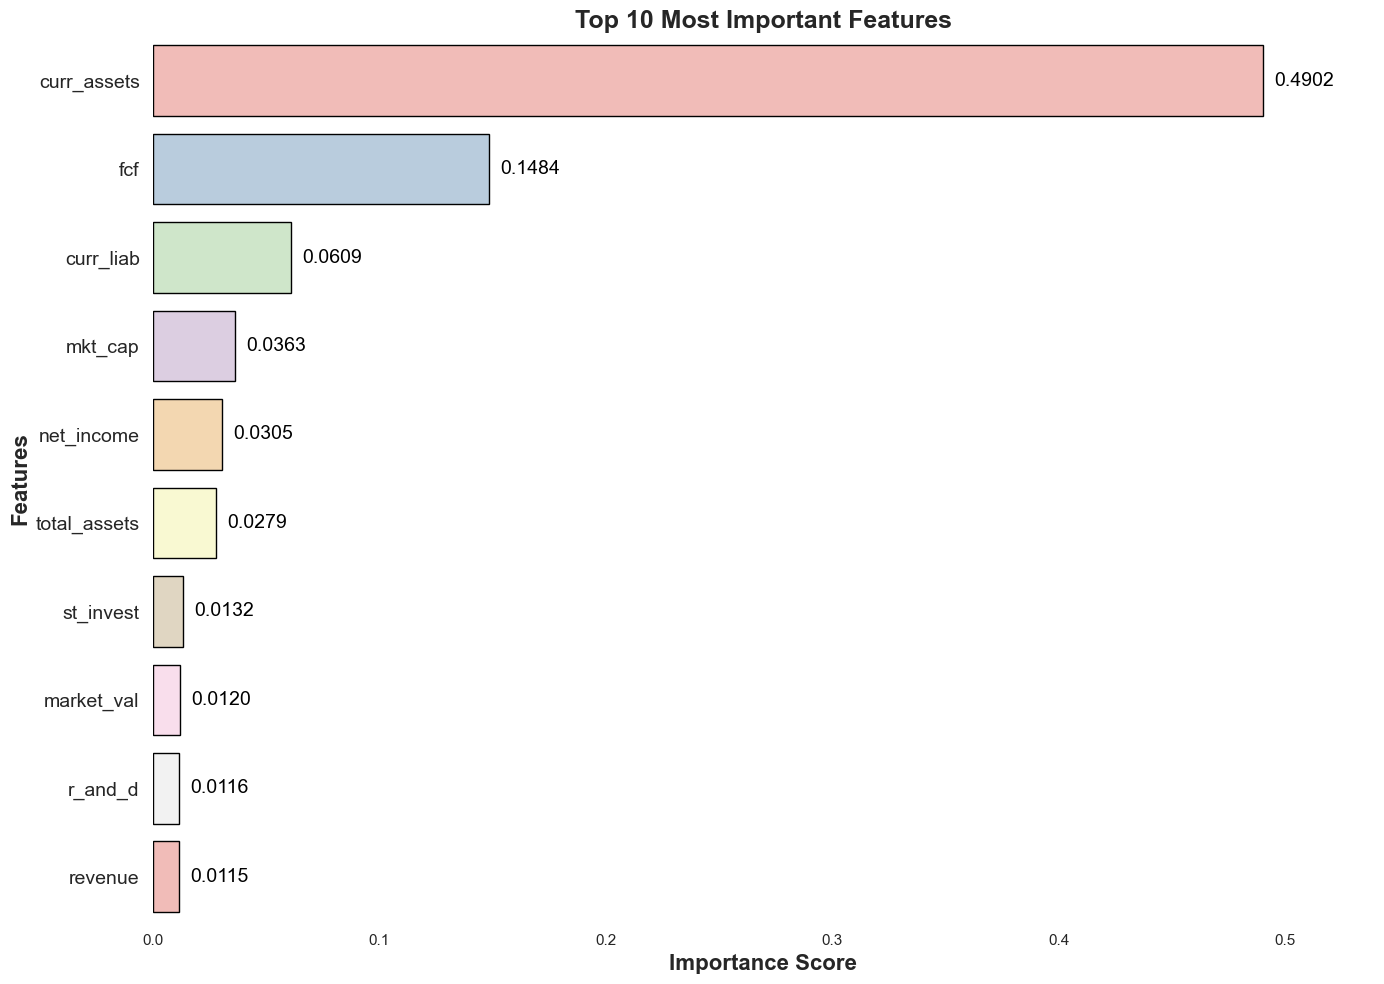

In [42]:
from matplotlib import rc

# 设置全局字体为Times New Roman
rc('font', family='Times New Roman')

# 设置 Seaborn 样式为 "white" 以去除网格线
sns.set(style="white")

top_n = 10
top_features = importance_df.head(top_n)

# 选择一个明亮的颜色调色板，例如 'Set2'
bright_palette = sns.color_palette("Pastel1", top_n)

# 创建图表
plt.figure(figsize=(14, 10))
sns.barplot(
    x='Importance',
    y='Feature',
    data=top_features,
    palette=bright_palette,
    edgecolor='black'
)

# 添加数值标签
for index, value in enumerate(top_features['Importance']):
    plt.text(
        value + top_features['Importance'].max() * 0.01,  # 在条形末端稍微偏右位置
        index,
        f'{value:.4f}',
        va='center',
        fontsize=14,
        color='black'
    )

# 设置轴标签和标题，增加字体大小和加粗
# 增大特征名称的字号
plt.yticks(fontsize=14, rotation=0)  # 水平条形图中，rotation=0 保持水平
plt.xlabel('Importance Score', fontsize=16, fontweight='bold')
plt.ylabel('Features', fontsize=16, fontweight='bold')
plt.title('Top 10 Most Important Features', fontsize=18, fontweight='bold')

# 移除顶部和右侧的脊线
sns.despine(left=True, bottom=True)

# 调整x轴范围以确保数值标签不被截断
plt.xlim(0, top_features['Importance'].max() * 1.1)

plt.tight_layout()
plt.savefig('feature_importance_top10_USA.png', dpi=400, bbox_inches='tight')
plt.show()


out_R2 = 0.9019
out_EVS = 0.9019
out_MSE = 55429.5132
out_MAE = 72.0433
out_MedAE = 5.3307
out_RMSE = 235.4347


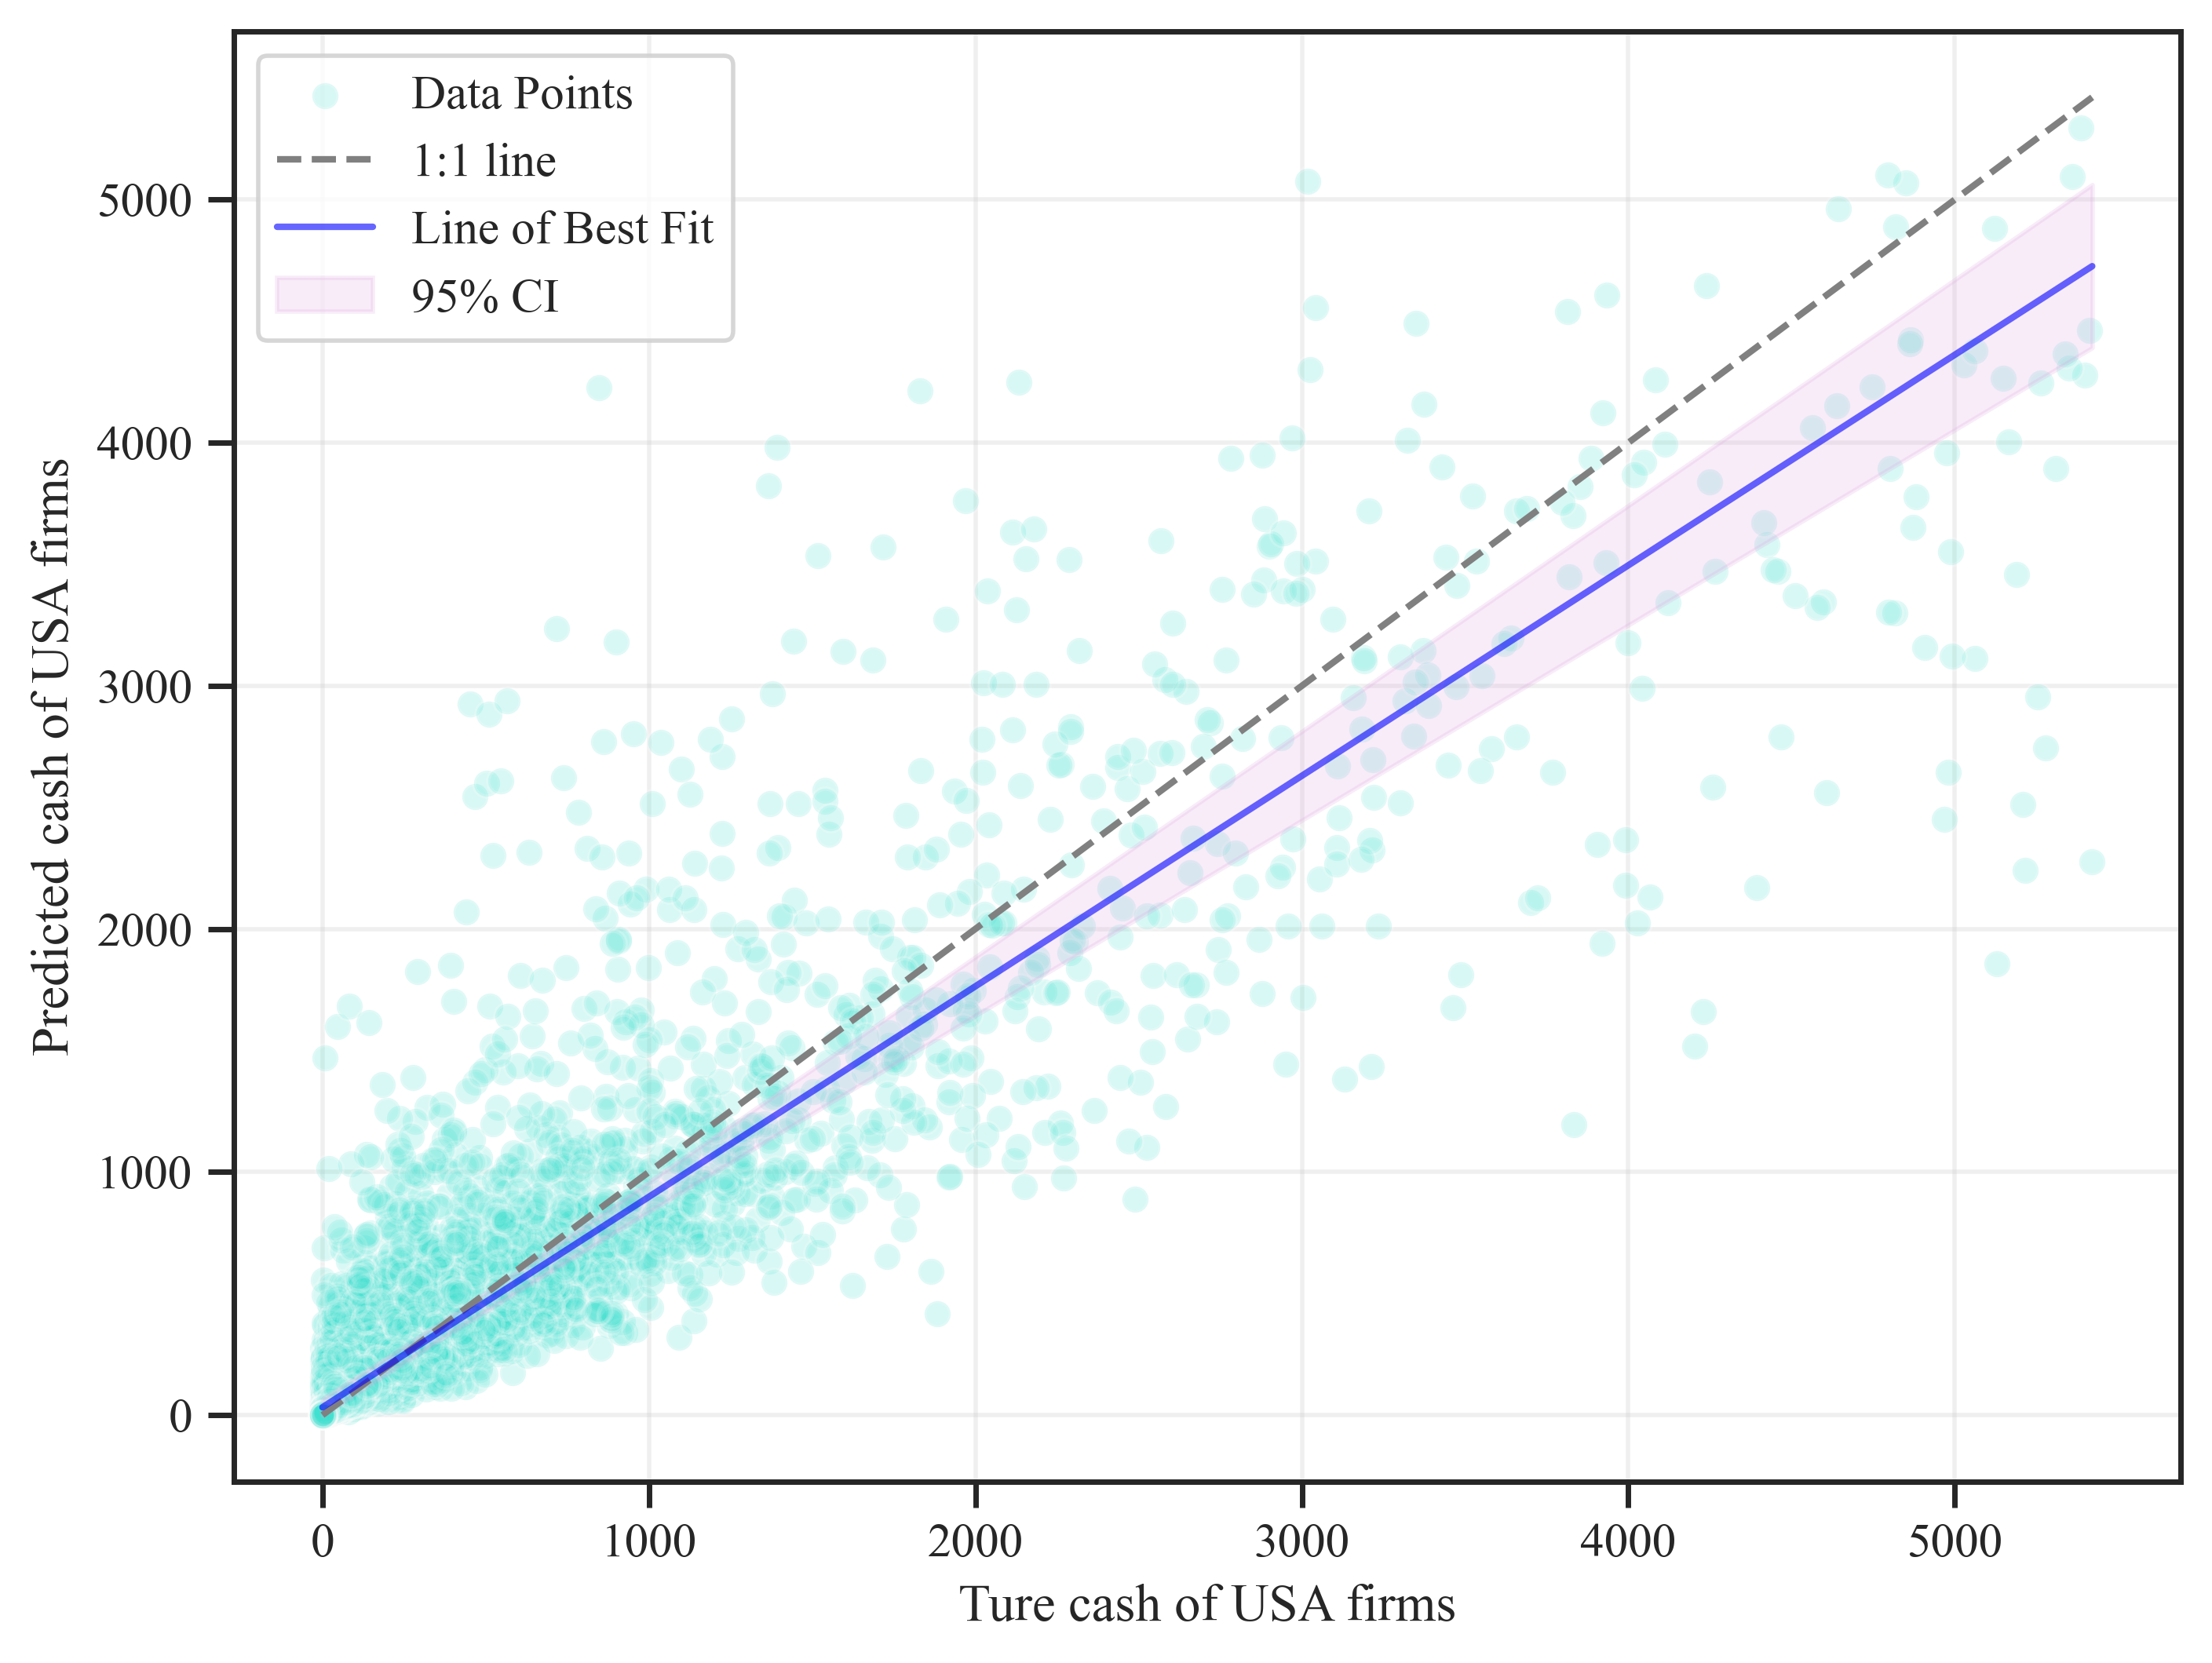

In [17]:
# 样本外预测指标
# 调用 score 函数输出原来的评估结果
score(y_valid, pred_rf_valid)
# 保存图表到本地，设置 dpi 为 400
plt.savefig('rf_model_performance_valid_USA.png', dpi=400, bbox_inches='tight')

# 样本外 R² (Out-of-sample R²)
out_sample_r2 = r2_score(y_valid, pred_rf_valid)
# 计算 EVS (Explained Variance Score)
evs = explained_variance_score(y_valid, pred_rf_valid)
# 计算 MSE (Mean Squared Error)
mse = mean_squared_error(y_valid, pred_rf_valid)
# 计算 MAE (Mean Absolute Error)
mae = mean_absolute_error(y_valid, pred_rf_valid)
# 计算 MedAE (Median Absolute Error)
medae = median_absolute_error(y_valid, pred_rf_valid)
# 计算 RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)
# 输出样本外评估指标
print('out_R2 = %.4f' % out_sample_r2)
print('out_EVS = %.4f' % evs)
print('out_MSE = %.4f' % mse)
print('out_MAE = %.4f' % mae)
print('out_MedAE = %.4f' % medae)
print('out_RMSE = %.4f' % rmse)

in_R2 = 0.9857
in_EVS = 0.9857
in_MSE = 7466.6092
in_MAE = 26.9170
in_MedAE = 1.8706
in_RMSE = 86.4095


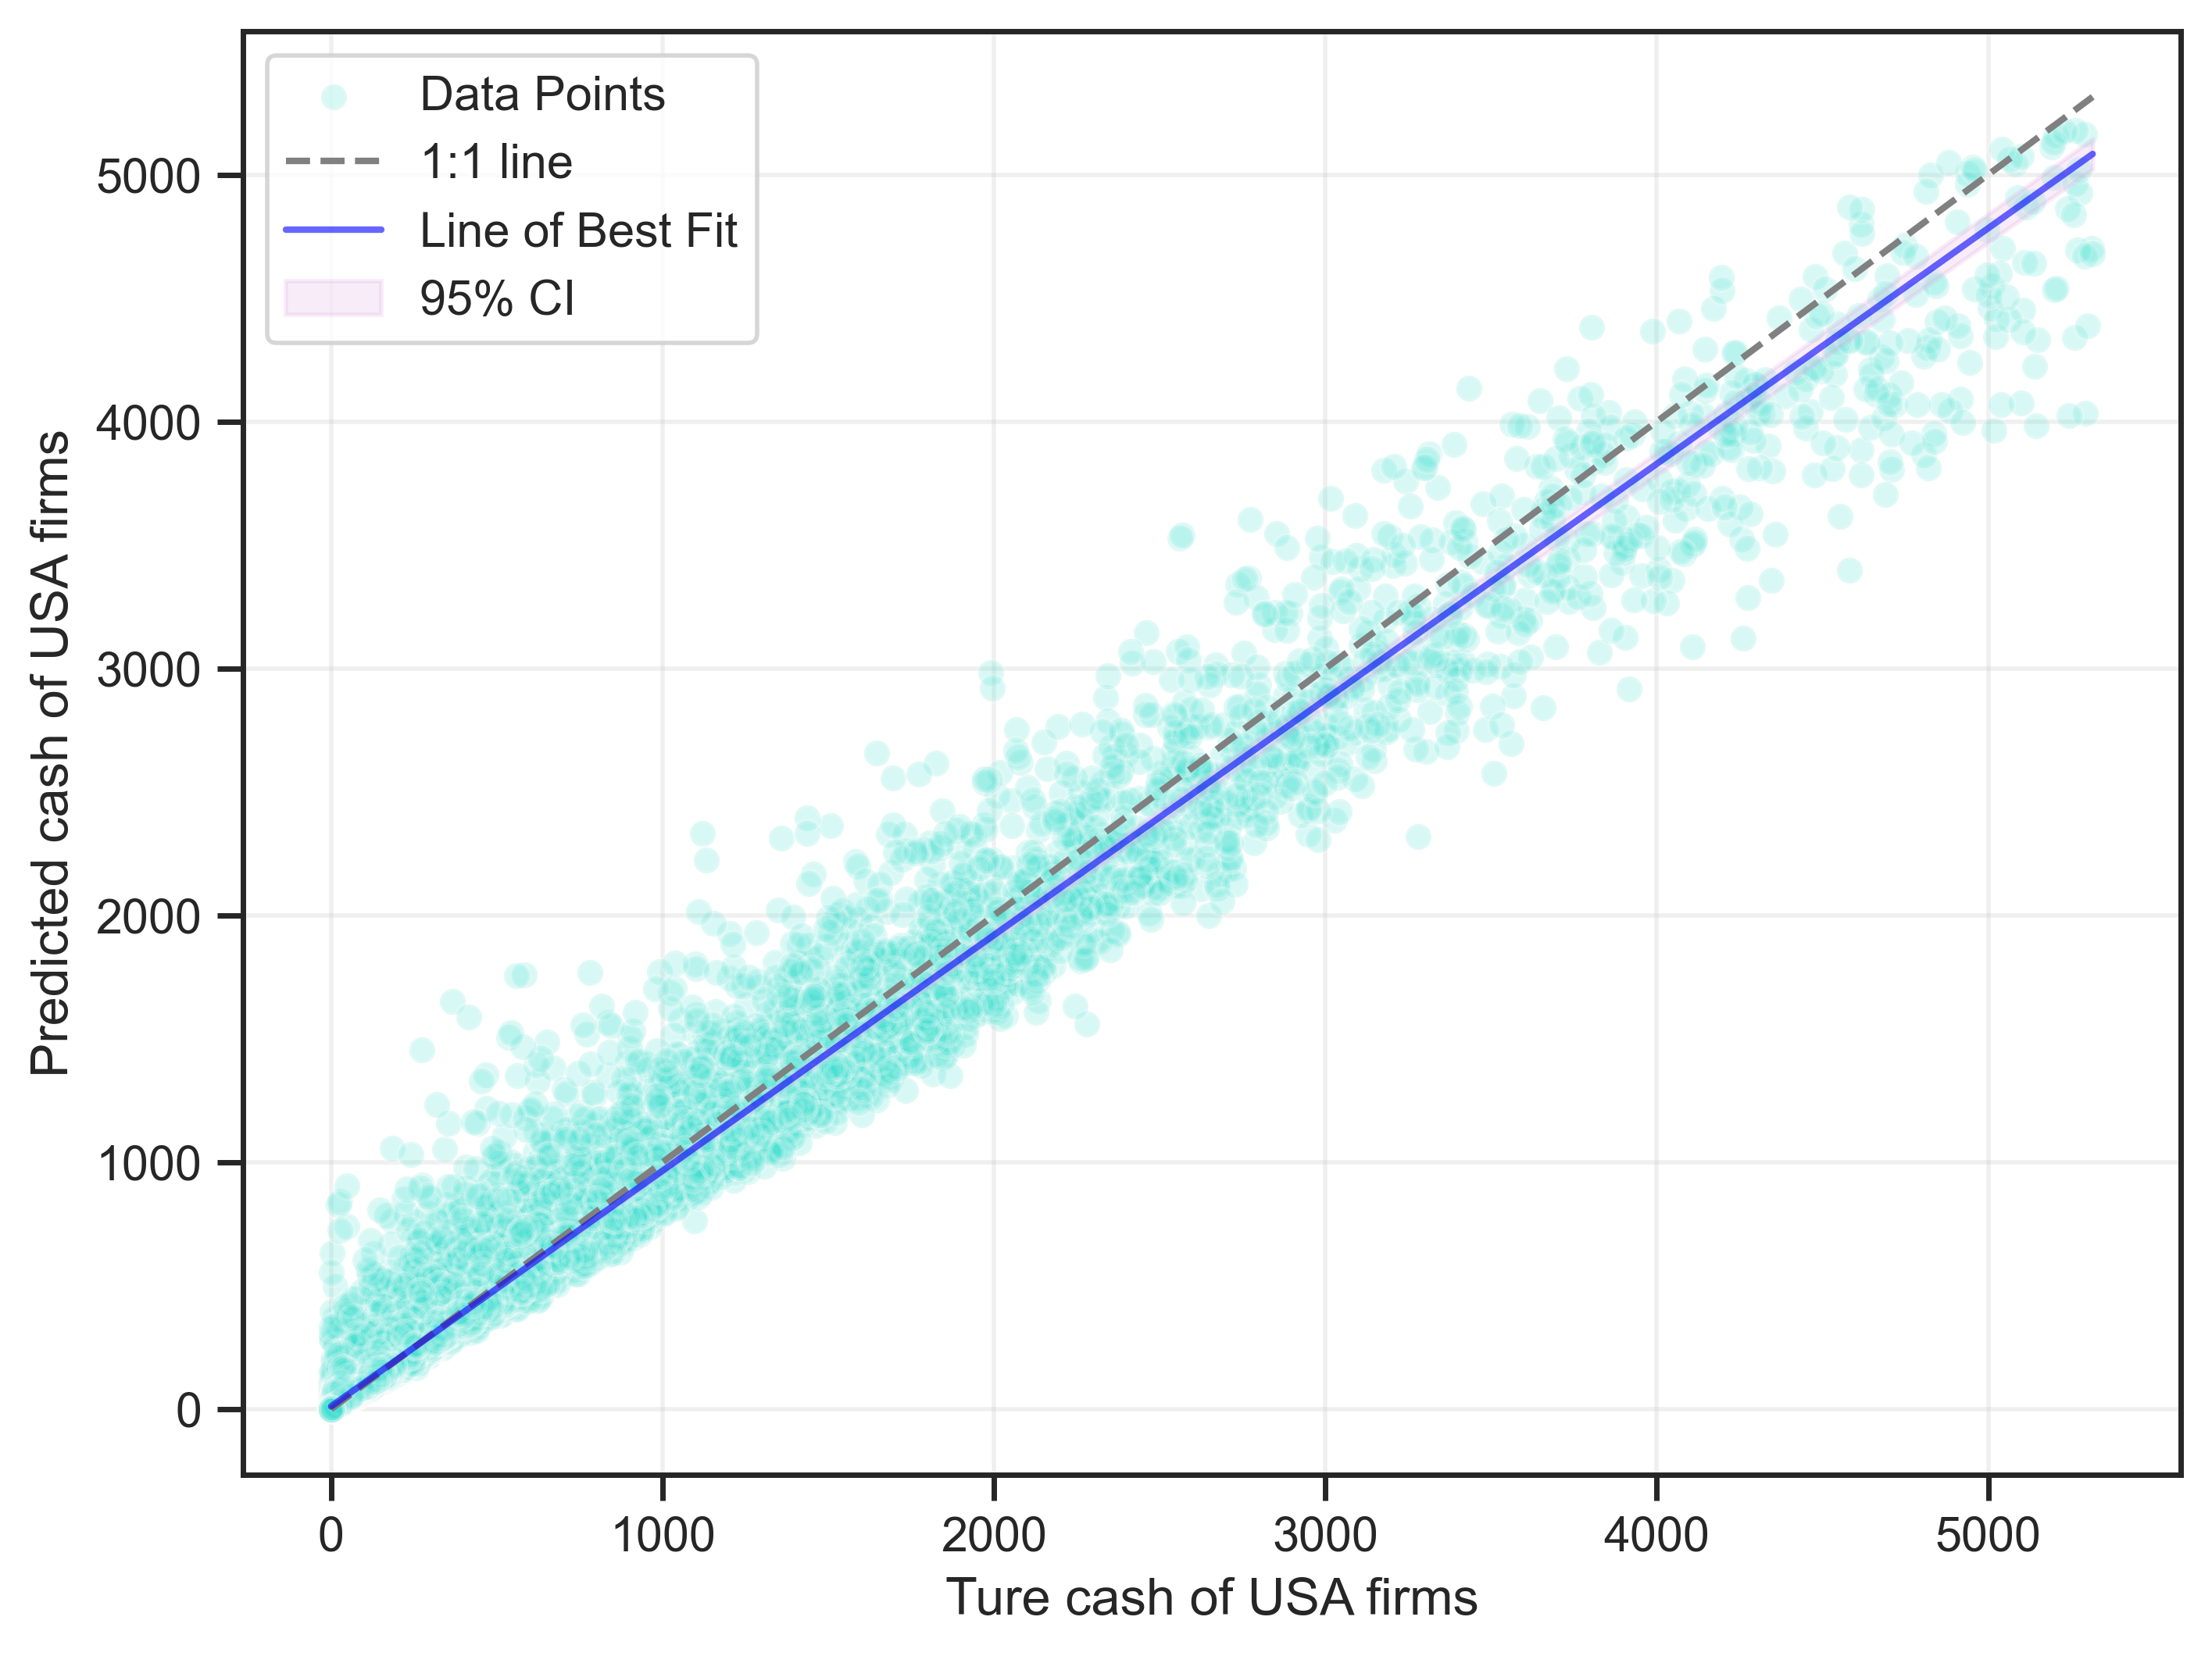

In [63]:
# 样本内预测指标
score(y_train, pred_rf_train)
# 保存图表到本地，设置 dpi 为 400
plt.savefig('rf_model_performance_train_USA.png', dpi=400, bbox_inches='tight')

# 样本内 R² (Training R²)
sample_in_r2 = r2_score(y_train, pred_rf_train)
# 计算 EVS (Explained Variance Score)
evs_train = explained_variance_score(y_train, pred_rf_train)
# 计算 MSE (Mean Squared Error)
mse_train = mean_squared_error(y_train, pred_rf_train)
# 计算 MAE (Mean Absolute Error)
mae_train = mean_absolute_error(y_train, pred_rf_train)
# 计算 MedAE (Median Absolute Error)
medae_train = median_absolute_error(y_train, pred_rf_train)
# 计算 RMSE (Root Mean Squared Error)
rmse_train = np.sqrt(mse_train)
# 输出样本内评估指标
print('in_R2 = %.4f' % sample_in_r2)
print('in_EVS = %.4f' % evs_train)
print('in_MSE = %.4f' % mse_train)
print('in_MAE = %.4f' % mae_train)
print('in_MedAE = %.4f' % medae_train)
print('in_RMSE = %.4f' % rmse_train)

In [18]:
# 提取特征和目标变量
dtest1 = data[data["country"] != 5]
dtest1 = dtest1.dropna()
dtest1 = winsorize_data(dtest1)

# 预测所需特征
X_test1 = dtest1.drop(columns=['comp_id', 'country', 'country_short', 'cash'])

# 将特征转化为 NumPy 数组
X_test1 = np.array(X_test1)

# 使用训练好的模型对 X_test1 进行预测
y_pred_dtest1 = rf_model.predict(X_test1)

# 将预测结果作为新的一列添加到 dtest1 中
dtest1['predicted_y1'] = y_pred_dtest1

# 只保留指定的列
columns_to_keep = ['comp_id', 'year', 'country_short', 'cash', 'total_assets', 'mkt_cap', 'sic', 'predicted_y1']
dtest1 = dtest1[columns_to_keep]

# 保存结果到本地 CSV 文件
dtest1.to_csv('dtest_all_predictions_USA.csv', index=False)

# 查看包含预测结果的 dtest1
print(dtest1.head())


    comp_id  year country_short   cash  total_assets  mkt_cap  sic  \
1  IQ100013  1998           THA  1.600     1975.4509    550.0   20   
2  IQ100013  1999           THA  1.050     2414.8796    550.0   20   
3  IQ100013  2000           THA  0.329     2346.3507    220.0   20   
4  IQ100013  2001           THA  0.304     2041.6563    180.0   20   
5  IQ100013  2002           THA  0.204     2043.5286    167.0   20   

   predicted_y1  
1    200.475585  
2    240.892146  
3    243.567478  
4    224.247496  
5    230.200696  


In [ ]:
'''#2=India
# 提取特征和目标变量
dtest2 = data[data["country"] == 2]
dtest2 = dtest2.dropna()
dtest2 = winsorize_data(dtest2)

X_test2 = dtest2.drop(columns=['comp_id', 'country', 'cash'])

#标准化特征变量
#sc = StandardScaler()
#sc.fit(X_test2)
#X_test2 = sc.transform(X_test2)
X_test2 = np.array(X_test2)

# 使用训练好的模型对X_test进行预测
y_pred_dtest2 = rf_model.predict(X_test2)

# 将预测结果作为新的一列添加到 dtest 中
dtest2['predicted_y2'] = y_pred_dtest2

# 保存带有预测结果的数据到本地 CSV 文件
dtest2.to_csv('dtest_India_predictions_USA.csv', index=False)

# 查看包含预测结果的 dtest
print(dtest2.head())  

In [ ]:
'''#3=China
# 提取特征和目标变量
dtest3 = data[data["country"] == 3]
dtest3 = dtest3.dropna()
dtest3 = winsorize_data(dtest3)

X_test3 = dtest3.drop(columns=['comp_id', 'country', 'cash'])

#标准化特征变量
#sc = StandardScaler()
#sc.fit(X_test3)
#X_test3 = sc.transform(X_test3)
X_test3 = np.array(X_test3)

# 使用训练好的模型对X_test进行预测
y_pred_dtest3 = rf_model.predict(X_test3)

# 将预测结果作为新的一列添加到 dtest 中
dtest3['predicted_y3'] = y_pred_dtest3

# 保存带有预测结果的数据到本地 CSV 文件
dtest3.to_csv('dtest_China_predictions_USA.csv', index=False)

# 查看包含预测结果的 dtest
print(dtest3.head())  

In [29]:
'''#4=EU
# 提取特征和目标变量
dtest4 = data[data["country"] == 4]
dtest4 = dtest4.dropna()
dtest4 = winsorize_data(dtest4)

X_test4 = dtest4.drop(columns=['comp_id', 'country', 'cash'])

#标准化特征变量
#sc = StandardScaler()
#sc.fit(X_test4)
#X_test4 = sc.transform(X_test4)
X_test4 = np.array(X_test4)

# 使用训练好的模型对X_test进行预测
y_pred_dtest4 = rf_model.predict(X_test4)

# 将预测结果作为新的一列添加到 dtest 中
dtest4['predicted_y4'] = y_pred_dtest4

# 保存带有预测结果的数据到本地 CSV 文件
dtest4.to_csv('dtest_EU_predictions.csv', index=False)

# 查看包含预测结果的 dtest
print(dtest4.head())  

         comp_id  year  revenue  total_assets  r_and_d  ebitda  st_invest  \
642  IQ100601859  2007    140.7       485.004      0.0    12.3        0.0   
643  IQ100601859  2008    163.9       681.926      0.0    11.0        0.0   
644  IQ100601859  2009    244.2       741.158      0.0    18.0        0.0   
645  IQ100601859  2010    328.9      1014.200      0.0    20.5        0.0   
646  IQ100601859  2011    495.8      1625.300      0.0    20.7        0.0   

       cash  tmax_pos        srad  ...    leverage   market_val  sic  \
642  12.700         4  104.814209  ...    8.489865     2.179000   59   
643   5.360         2  109.478760  ...   59.592773    96.812996   59   
644   0.426         2  109.787987  ...  588.646660   257.954010   59   
645  64.200         1  104.920792  ...   59.780720  2197.003174   59   
646  60.800         3  108.118729  ...   87.419121  2811.732178   59   

              GDP     GDP_pc  GDP_growth  inflation  inst_own  public_own  \
642  4.495848e+11  49145.19